# Grid and Feature Contribution version 2

This document shows the procedure of grid search and feature contribution investigation.

In [1]:
from __future__ import division
import pandas as pd
import numpy as np 
import matplotlib.pylab as plt
from code.organize import *
from code.roughEDA import *
from code.survey_processor_full import *
from code.model_vis import *

from sklearn.cross_validation import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import roc_auc_score, confusion_matrix,roc_curve
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import cross_val_score
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.decomposition import PCA

from treeinterpreter import treeinterpreter as ti
import matplotlib.cm as cm
import cPickle as pickle
%matplotlib inline
%load_ext autoreload
%autoreload 2

Load data

In [2]:
sv = survey('data/survey2/')

In [3]:
sv.num_processor()

In [4]:
df = sv.fin_data

Split data to training and testing sets

In [5]:
dfc = df.copy()

y = dfc.pop('employed').values
X = dfc.values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=90)

### 1. Fit random forest model

In [6]:
rf = RandomForestClassifier(n_jobs=-1,random_state=0)
rf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

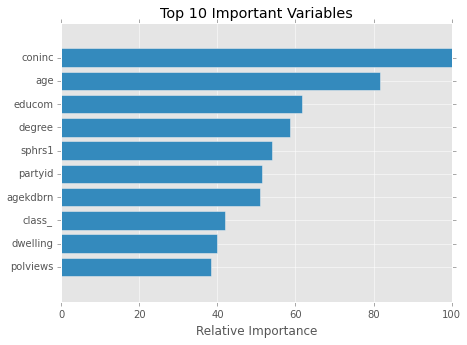

In [7]:
plt.figure(figsize=(7,5))
plot_importance(rf,dfc,10)
plt.title('Top 10 Important Variables')

#### Take first 40 important features to model

In [8]:
f40 = rf.feature_importances_.argsort()[::-1][:40]

slct=dfc.columns[f40]   #select top 40 features
X = dfc[slct].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=90)

In [9]:
rf_redu = RandomForestClassifier(n_jobs=-1,random_state=0)
rf_redu.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

## 2. Grid search

In [10]:
#1st round
# rf_grid = {'max_depth': [3, None], 
#                       'max_features': ['sqrt', 'log2', None],
#                       'min_samples_split': [1, 2, 4],
#                       'min_samples_leaf': [1, 2, 4],
#                       'bootstrap': [True, False],
#                       'n_estimators': [10, 20, 40],
#                       'random_state': [1]}

# #2nd
# rf_grid = {'max_depth': [None], 
#            'criterion':['gini','entropy'],
#                       'max_features': ['log2', None],
#                       'min_samples_split': [1],
#                       'min_samples_leaf': [2],
#                       'bootstrap': [True, False],
#                       'n_estimators': [30, 40,80],
#                       'random_state': [1]}

# #3rd 
# rf_grid = {'max_depth': [None], 
#            'criterion':['entropy'],
#                       'max_features': ['log2',None],
#                       'min_samples_split': [1],
#                       'min_samples_leaf': [2],
#                       'bootstrap': [False],
#                       'n_estimators': [60,80,100],
#                       'random_state': [1]}
# #last round
rf_grid = {'max_depth': [None], 
           'criterion':['entropy'],
                      'max_features': ['log2',None,],
                      'min_samples_split': [1],
                      'min_samples_leaf': [2],
                      'bootstrap': [False],
                      'n_estimators': [230,250,300],
                      'random_state': [1]}

In [11]:
rf_gridsearch = GridSearchCV(RandomForestClassifier(),
                             rf_grid,
                             n_jobs=-1,
                             verbose=True,
                             scoring='roc_auc')

In [12]:
rf_gridsearch.fit(X_train,y_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:   30.3s finished


GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'n_estimators': [230, 250, 300], 'min_samples_split': [1], 'random_state': [1], 'criterion': ['entropy'], 'max_features': ['log2', None], 'bootstrap': [False], 'max_depth': [None], 'min_samples_leaf': [2]},
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc',
       verbose=True)

In [13]:
rf_gridsearch.best_params_

{'bootstrap': False,
 'criterion': 'entropy',
 'max_depth': None,
 'max_features': 'log2',
 'min_samples_leaf': 2,
 'min_samples_split': 1,
 'n_estimators': 300,
 'random_state': 1}

In [14]:
best_rf = rf_gridsearch.best_estimator_

Make a roc curve.

roc_auc_score : 0.811187131244


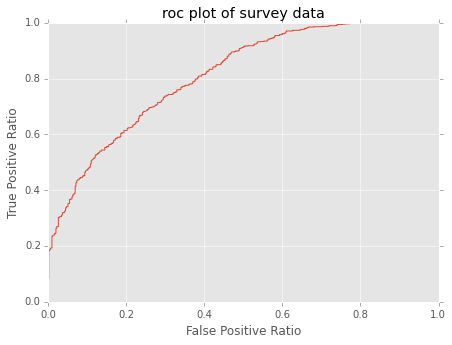

In [15]:
plt.figure(figsize=(7,5))
plt.title('roc plot of survey data')
plot_roc(best_rf,X_test,y_test)

plt.savefig('imgs/readme_figs/roc_curve')

### 3.  Tree Interpreter and Feature Contribution

In order to know the influence of each variable on the model, feature contribution algorithm is applied. 

In [27]:
prediction, bias, contributions = ti.predict(best_rf, X)

## 4. make feature contribution data frame

In [28]:
fc_df = pd.DataFrame(contributions[:,:,1], columns=slct)

In [29]:
fc_df['predict'] = best_rf.predict(X)    # predicted result

In [30]:
fc_df['employed'] = y                   # true result

In [31]:
fc_df['correct'] = fc_df.predict == fc_df.employed      # check if the prediction is correct

In [32]:
fc_df.drop('predict',axis =1, inplace=True)               #subset correct instances

Running tree interpreter takes a long time. So pickle it and move on to the next step. 

In [36]:
with open('data/fc_df2.pkl','w') as f:
    pickle.dump(fc_df,f)

In [46]:
a = pd.read_pickle('data/fc_df2.pkl')
a.head()

,coninc,age,educom,degree,sphrs1,partyid,agekdbrn,class_,dwelling,polviews,...,mobile16,natfare,marital,divlaw,affrmact,helpnot,life,spanking,employed,correct
0,-0.024180,0.012212,0.004822,0.025785,0.003010,0.005950,0.023872,-0.082842,-0.039021,-0.005935,...,-0.006342,0.023788,0.004271,0.003521,0.000336,-0.004642,0.000422,0.000950,True,True
1,0.002730,-0.004376,0.008302,0.014275,-0.018376,-0.000277,0.007874,-0.041408,0.012293,0.000421,...,-0.002230,0.007787,-0.008250,0.001585,-0.000391,0.003435,0.006826,0.008383,False,False
2,-0.008768,0.027119,-0.038023,0.013832,-0.044665,-0.012495,-0.019889,-0.049807,-0.004495,-0.002228,...,0.000816,-0.010834,-0.012121,-0.003478,-0.004329,-0.025902,-0.008582,-0.011836,False,True
3,0.007878,-0.046130,-0.012555,-0.001003,0.012358,-0.033311,-0.032281,-0.047386,-0.012148,-0.015564,...,-0.015081,0.006761,0.002884,-0.021230,-0.013306,-0.001434,-0.002780,-0.005327,False,True
4,-0.113355,-0.023602,-0.129956,0.013399,-0.004473,-0.002051,-0.034877,-0.017012,-0.046539,-0.016746,...,-0.032639,-0.004402,0.010967,0.009405,-0.028089,0.003807,-0.001978,-0.006098,False,True
